In [1]:
import numpy as np
import wfdb
from os import path
import os
import matplotlib.pyplot as plt
import os
from os import path
from keras.saving import load_model

%matplotlib inline

2024-09-22 13:05:33.038797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
records = ["a01r", "a02r", "a03r", "a04r", "b01r", "c01r", "c02r", "c03r"]
batch_size = 64
epochs = 1

def get_patients(plist):
    def get_patient(patientid):
        rec = np.load(path.join("numpy", f"patient_{patientid+1}.npy"))
        ann = np.load(path.join("numpy", f"annotation_{patientid+1}.npy"))
        # rec = rec.reshape(len(ann), 6000, 2)
        return rec, ann
    X, y = get_patient(plist[0])
    siglen = len(y)
    plist = plist[1::]
    for i in plist:
        rec, ann = get_patient(i)
        X = np.hstack((X, rec))
        y = np.hstack((y, ann))
        siglen += len(ann)

    X = np.array(np.split(X, siglen, axis=1))
    X = np.array([rec.T for rec in X])
    return X, y

def smoothing(y, unit):
    size = len(y)
    ans = np.array(np.split(np.array(y), size // unit))
    ans = np.mean(ans, axis=1)
    ans = ans.flatten()
    return np.array(ans)

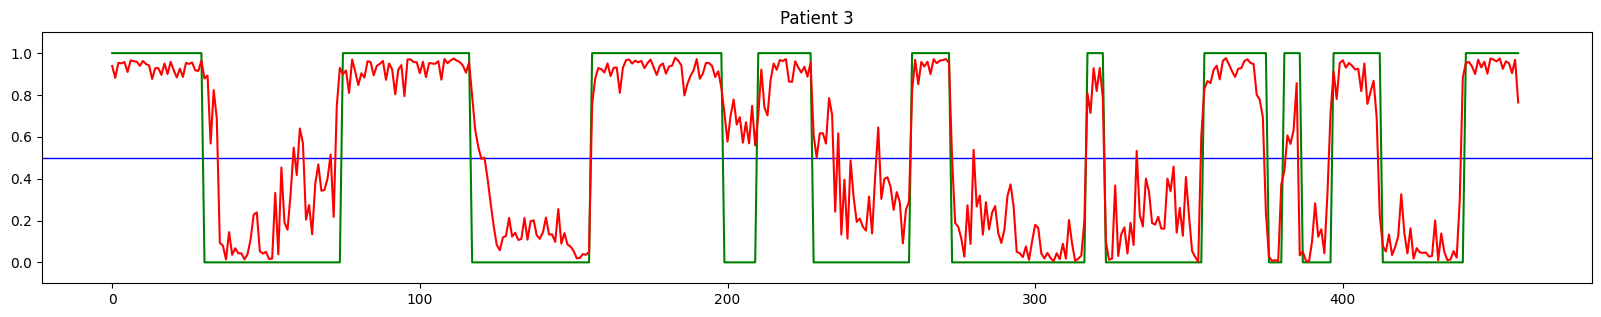

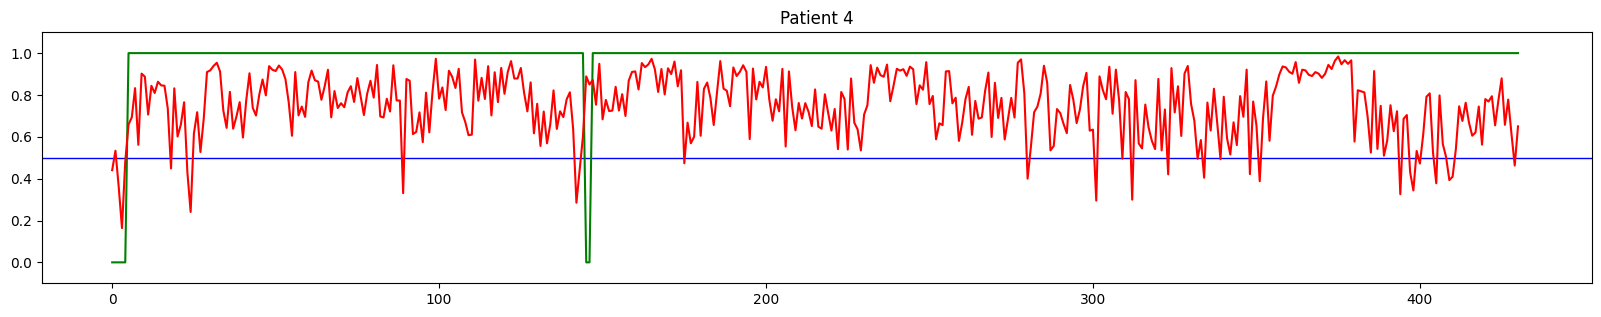

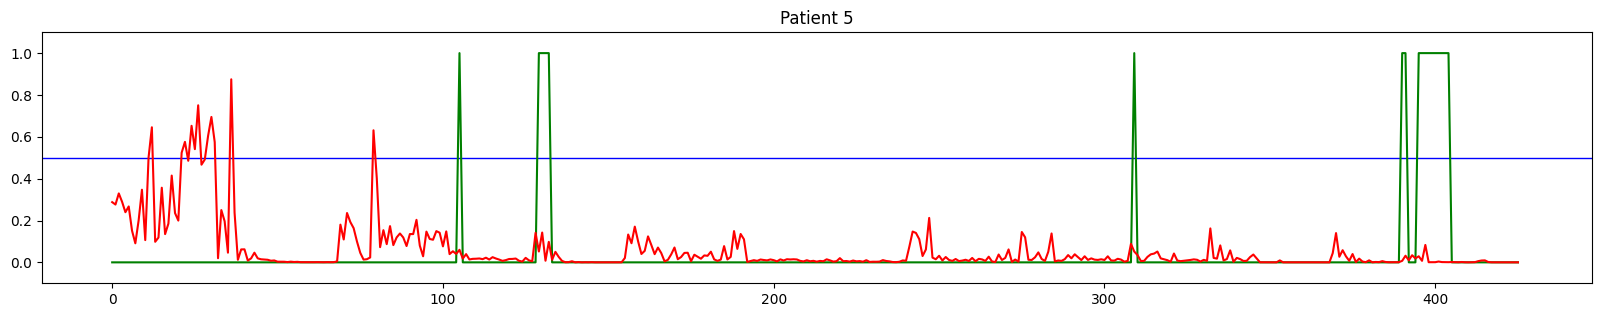

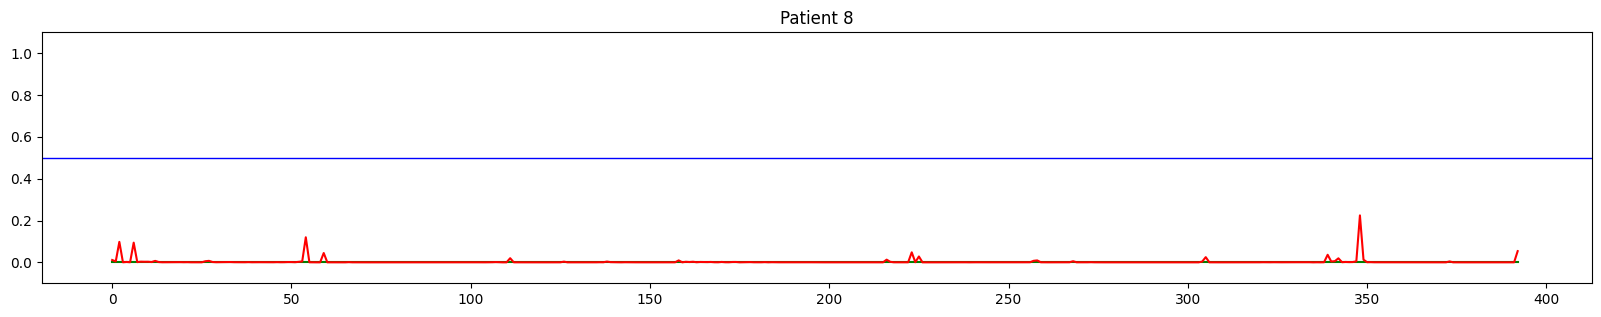

In [3]:
save_path = path.join("res", "model.keras")
model = load_model(save_path)

# test = [0, 1, 2, 3, 4, 5, 6, 7]
test = [2, 3, 4, 7]

for idx, i in enumerate(test):
    X, y = get_patients([i])
    pred = model.predict(X, verbose=False)
    pred = pred.flatten()

    y = smoothing(y, 6)
    pred = smoothing(pred, 6)
    rpred = [np.round(a) for a in pred]
    
    plt.figure(figsize=(20, 15))
    plt.subplot(len(test), 1, idx+1) 
    plt.title(f"Patient {i+1}")
    ar = range(len(y))
    # plt.scatter(ar, rpred, color="r", marker="*")
    # plt.scatter(ar, y, color="g")
    plt.axline((0, 0.5), (len(y), 0.5), color="b", linewidth=1)
    plt.plot(y, color="g")
    plt.plot(pred, color="r")
    plt.ylim(-0.1, 1.1)
    plt.show()

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 998, 16)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 499, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 497, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 248, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 246, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 123, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 121, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 60, 6)          │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       184,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,444,211 (5.51 MB)

 Trainable params: 481,403 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 962,808 (3.67 MB)